Test with Acropora abrolhosensis https://www.marinespecies.org/aphia.php?p=taxdetails&id=288182
aphiaID = 288182  
urn = urn:lsid:marinespecies.org:taxname:288182

In [1]:
import json
from urllib.request import urlopen
import urllib.parse
import pandas as pd

Build OBIS API query

In [2]:
base = 'https://api.obis.org/v3/'

aphiaID = '342218'

fields = ['decimalLatitude','decimalLongitude','occurrenceID','id',
          'datasetName','dataset_id','eventDate','species','aphiaID',
          'date_year']

f = "%2C".join([f"{v}" for v in fields])

# define a polygon
# bound it somehow to between 30 deg N and S latitude
#geometry=urllib.parse.quote("POLYGON ((-180 -30, 180 -30, 180 30, -180 30, -180 -30))")

#depth = [0, 30]

# How many responses do you want back? Max=10000
size = 10000

#occurrence_id = 'occurrence?taxonid={}&startdepth={}&enddepth={}&geometry={}&size={}'.format(aphiaID,depth[0],depth[1],geometry,size)
occurrence_id = 'occurrence?taxonid={}&size={}'.format(aphiaID,size)


#taxon_id = 'taxon/{}'.format(aphiaID)
#taxon_sn = 'taxon/{}'.format(scientificname)

url = '{}{}'.format(base,occurrence_id)

url

'https://api.obis.org/v3/occurrence?taxonid=342218&size=10000'

Download the data from OBIS API into pandas DataFrame

In [3]:
response= urlopen(url)

data_json = json.loads(response.read())

data = pd.DataFrame(data_json['results'])

size = data_json['total']

print("Found %i records." % size)
print("See in mapper at: %s" % '{}{}#'.format('https://mapper.obis.org/?',occurrence_id.replace("occurrence?","")))

Found 221 records.
See in mapper at: https://mapper.obis.org/?taxonid=342218&size=10000#


Save DataFrame as GeoDataFrame

In [4]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.decimalLongitude, data.decimalLatitude),
    crs="EPSG:4326")

Bin to 1 degree cells

bin to one degree cells across globe

In [5]:
34601*2 + 34601*2

138404

In [6]:
import numpy as np
import shapely

# total area for the grid
xmin, ymin, xmax, ymax= [-180., -90., 180., 90]
# how many cells across and down
n_cells=360
cell_size = (xmax-xmin)/n_cells
# projection of the grid
#crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
        
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs="EPSG:4326")
    
# ax = gdf.plot(markersize=.1, figsize=(12, 8),)# column='dob', cmap='jet')
# plt.autoscale(False)
# cell.plot(ax=ax, facecolor="none", edgecolor='grey')
# ax.axis("off")

merged = gpd.sjoin(gdf, cell, how='left', op='within')

# make a simple count variable that we can sum
merged['n_occur'] = 1
# Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = merged.dissolve(by="index_right", aggfunc="count")
# put this into cell
cell.loc[dissolve.index, 'n_occur'] = dissolve.n_occur.values

cell = cell[~cell['n_occur'].isna()]

cell['area (km2)'] = cell.to_crs(epsg=3763).area/(1000**2)

cell['density (#/km2)'] = cell['n_occur']/cell['area (km2)']

C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [7]:
cell[['n_occur','density (#/km2)']]

,n_occur,density (#/km2)
226,1.0,0.000112
408,1.0,0.000110
590,3.0,0.000322
1313,1.0,0.000108
2226,1.0,0.000092
...,...,...
64844,1.0,0.000111
65020,1.0,0.000121
65021,1.0,0.000119
65206,1.0,0.000110


Now make the plot using geopandas built in plot

(-18491143.68863403, 18491143.68863403, -9473562.580980353, 9191411.568387408)

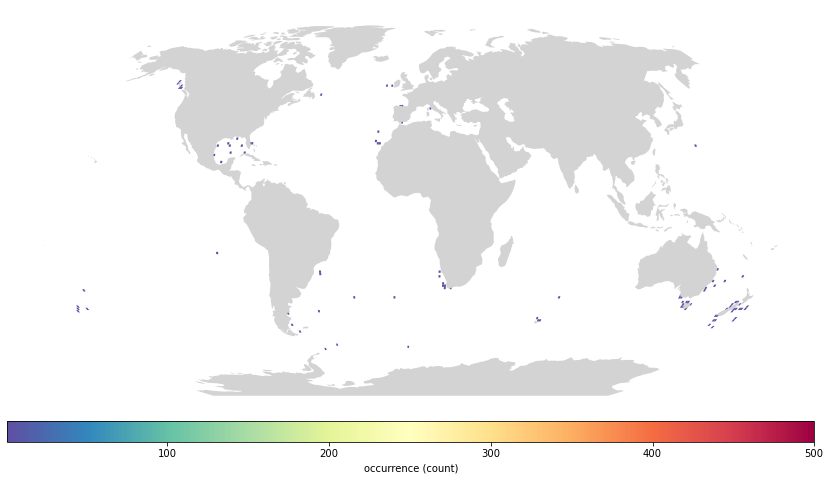

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pycrs
import geoplot as gplt

crs = pycrs.parse.from_esri_code(54030)
#crs.geogcs.prime_mer.value = 160.0
crs_str = crs.to_proj4()

#fig, ax = plt.subplots(figsize=(16,8), facecolor='white')
#ax = plt.subplot(1, 4, 4, figsize=(16,8))

fig = plt.figure(figsize=(16, 8))

#mol = ccrs.Mollweide()
ax = fig.add_subplot(1, 1, 1,)

# start map with entire world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.dissolve()

# world.to_crs(crs_str).plot( ax=ax,
#                             color='lightgrey', 
#                             edgecolor=None,
#                             linewidth=None
#                             )

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

# plot the gridded occurrence cells
cell.to_crs(crs_str).plot( ax=ax,
                           column='n_occur', 
                           cmap='Spectral_r', 
                           vmin=1, 
                           vmax=500, 
                           edgecolor=None, 
                           legend=True,
                           legend_kwds={'label': "occurrence (count)",
                                        'orientation': "horizontal"},
                           cax=cax,
                           )

plt.autoscale(False)

world.to_crs(crs_str).plot( ax=ax,
                            color='lightgrey', 
                            edgecolor=None,
                            linewidth=None
                            )

#ax.outline_patch.set_visible(True)
#world.to_crs("ESRI:54009").plot(ax=ax, color='none', edgecolor='black',linewidth=.5)
ax.axis('off')
#plt.grid(True)

Use geoplot

C:\Users\MATHEW~1.BID\AppData\Local\Temp\7/ipykernel_20784/1752485702.py:57: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(True)


<GeoAxesSubplot:>

C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\mpl\gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\mpl\gridliner.py:561: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for inter in intersection:
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\mpl\gridliner.py:556: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(inters

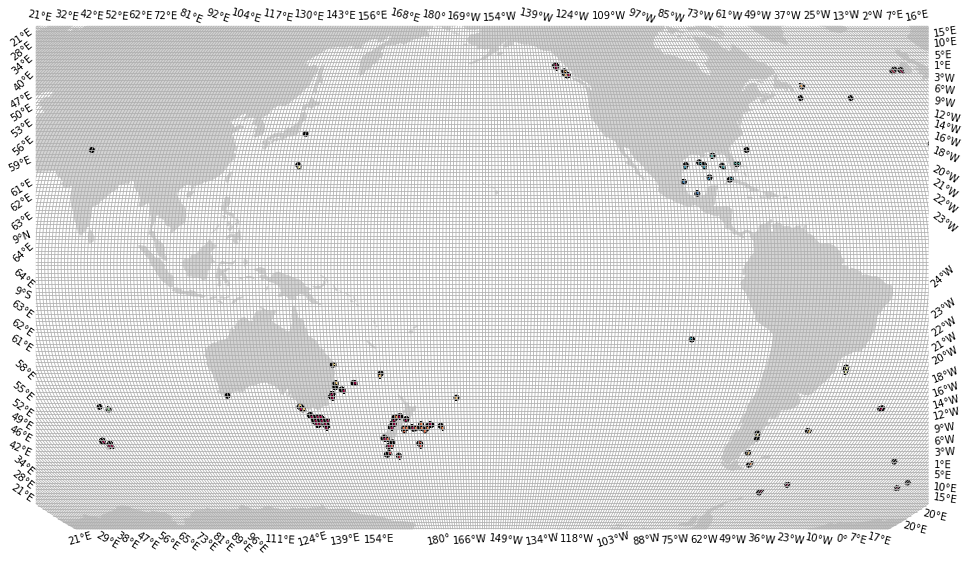

In [9]:
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker

norm = mpl.colors.Normalize(vmin=0, vmax=0.000142)

projection=gcrs.Robinson(central_longitude=-160)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.dissolve()

#fig, ax = plt.subplots(figsize=(16,16), facecolor='white', subplot_kw={'projection':projection})

ax = geoplot.polyplot(
    world,
    figsize=(16,16),
    facecolor='lightgray',
    edgecolor=None,
    projection=projection,
   # ax=ax,
)

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("bottom", size="5%", pad=0.1)

#cax = fig.add_axes([0.125, 0.08, 0.775, 0.03])

# cell[~cell['n_occur'].isna()]

#cell = cell[~cell['n_occur'].isna()]



geoplot.choropleth(cell, 
                   hue='density (#/km2)', 
                   edgecolor='black', 
                   projection=projection, 
                   ax=ax,
                   cmap='Spectral_r',
#                    legend=True,
#                    legend_kwargs={'orientation': 'horizontal',
#                                   #'cax':cax,
#                                   'label':"occurrence (count)",
#                                  },
                   norm=norm, 
                  )







ax.outline_patch.set_visible(True)
#ax.set_global(); 

gl = ax.gridlines(draw_labels=True)
gl.ylocator = mticker.FixedLocator(range(-90,90,1)) #-75, -50, -25, 0, 25, 50, 75, 90])
gl.xlocator = mticker.FixedLocator(range(-180,180,1)) #-75, -50, -25, 0, 25, 50, 75, 90])

geoplot.pointplot(gdf, ax=ax, projection=projection, color='black', s=5)

order = [0,2,1,3]
extent = [cell.total_bounds[i] for i in order]

ax.set_extent(extent)

In [10]:
print("records:",data.shape[0])
print("Years: %i - %i" % (data["date_year"].astype(float).min(),data["date_year"].astype(float).max()))
print("Species:", len(data['species'].dropna().unique()))
print("Taxa:", len(data['aphiaID'].dropna().unique()))

records: 221
Years: 1871 - 2020
Species: 1
Taxa: 1


Create a histogram by year

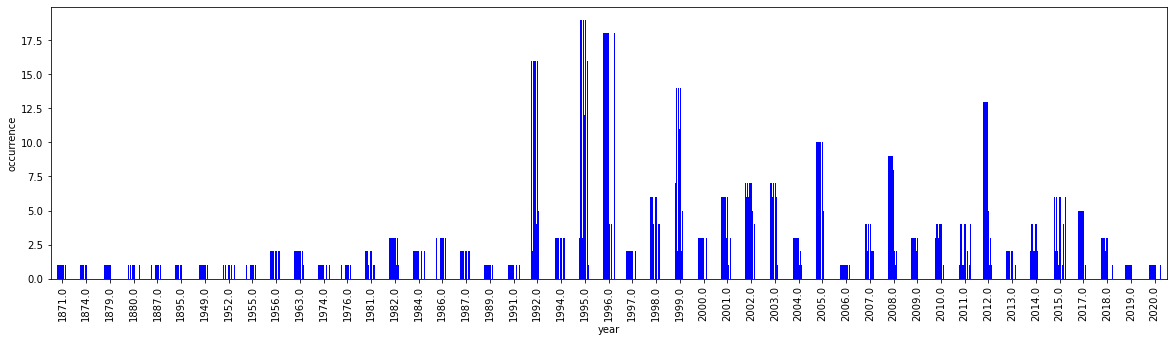

In [11]:
import matplotlib as plt

data['date'] = pd.to_datetime(data['date_year'],format="%Y")

year_group = data.groupby(data['date'].dt.year)

ax = year_group.count().plot(kind="bar", 
                             color='blue',
                             legend=False, 
                             figsize=(20, 5),
                             ylabel='occurrence',
                             xlabel='year',
                            )

#ax.xaxis.set_major_locator(plt.ticker.MaxNLocator(1))

Create a histogram by latitude

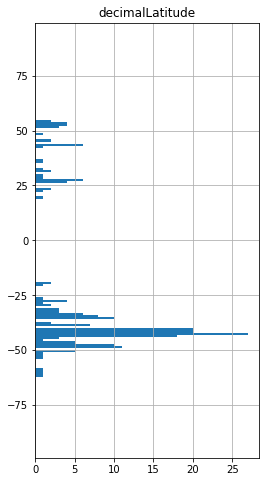

In [12]:
import matplotlib.pyplot as plt
bins = [i for i in range(-90, 91, 1)]

fig, ax = plt.subplots(figsize=(4,8))

data.hist(column='decimalLatitude', bins=bins, orientation='horizontal', ax=ax)
plt.xlabel='occurrence (count)'
plt.title=''
# latitude_group = cell.groupby('n_occur')
# latitude_group['n_occur'].count().plot()

Combine the map and histogram

C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\geoplot\geoplot.py:623: UserWarning: Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.
  warnings.warn(
C:\Users\MATHEW~1.BID\AppData\Local\Temp\7/ipykernel_20784/1884796911.py:49: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.set_global(); ax.outline_patch.set_visible(True);


array([<Axes:title={'center':'decimalLatitude'}>], dtype=object)

C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\mpl\gridliner.py:549: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\cartopy\mpl\gridliner.py:556: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], intersection[-1],
<__array_function__ internals>:180: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\numpy\lib\function_base.py:5392: ShapelyDe

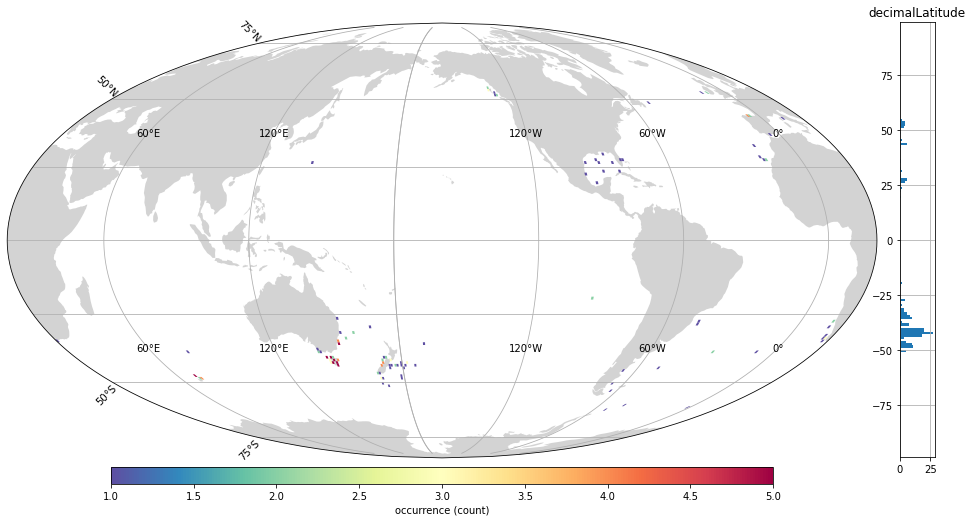

In [13]:
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

norm = mpl.colors.Normalize(vmin=1, vmax=5)

projection=gcrs.Mollweide(central_longitude=-160)
#projection=gcrs.Robinson(central_longitude=-160)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.dissolve()

fig, ax = plt.subplots(figsize=(16,8), facecolor='white', subplot_kw={'projection':projection})

geoplot.polyplot(
    world,
    figsize=(16,8),
    facecolor='lightgray',
    edgecolor=None,
    projection=projection,
    ax=ax,
)

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("bottom", size="5%", pad=0.1)

cax = fig.add_axes([0.225, 0.08, 0.575, 0.03])

# cell[~cell['n_occur'].isna()]

cell = cell[~cell['n_occur'].isna()]

geoplot.choropleth(cell, 
                   hue='n_occur', 
                   edgecolor=None, 
                   projection=projection, 
                   ax=ax,
                   cmap='Spectral_r',
                   legend=True,
                   legend_kwargs={'orientation': 'horizontal',
                                  'cax':cax,
                                  'label':"occurrence (count)",
                                 },
                   norm=norm, 
                  )

ax.set_global(); ax.outline_patch.set_visible(True); 

import matplotlib.ticker as mticker

gl = ax.gridlines(draw_labels=True)
gl.ylocator = mticker.FixedLocator([-90, -75, -50, -25, 0, 25, 50, 75, 90])

# [0.91, 0.125, 0.03, 0.7555]

ax2 = fig.add_axes([0.91, 0.1257, 0.03, 0.7555])

bins = [i for i in range(-90, 91, 1)]

data.hist(column='decimalLatitude', bins=bins, orientation='horizontal', ax=ax2, )
#data = gdf.to_crs(projection)
#count, lat = pd.np.histogram(data['decimalLatitude'], bins=bins)

#ax2.plot(count,lat[:-1])

#ax2.sharey(ax)

#yticks = ax.yaxis.get_major_ticks()

#ax2.set_yticks(yticks)

#plt.title('')

In [14]:
cell.explore()